In [1]:
import os
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from PIL import Image
import io
import datetime

___
# CLASSIFICATOR FITTING

Example mainly adopted from

https://www.kaggle.com/code/texasdave/image-classification-tutorial-with-mnist-fashion

Date (2023-10-17)

By T. Glaubach
___

In [2]:
import random

In [3]:
!python --version

Python 3.10.5


In [4]:
%pip show tensorflow

Name: tensorflow
Version: 2.13.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /opt/conda/lib/python3.10/site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [5]:
%pip show keras

Name: keras
Version: 2.13.1
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: /opt/conda/lib/python3.10/site-packages
Requires: 
Required-by: tensorflow
Note: you may need to restart the kernel to use updated packages.


In [6]:
!pip freeze

absl-py==2.0.0
aiokatcp==1.6.2
alembic @ file:///home/conda/feedstock_root/build_artifacts/alembic_1657813896088/work
anyio @ file:///home/conda/feedstock_root/build_artifacts/anyio_1652463865103/work/dist
argon2-cffi @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi_1640817743617/work
argon2-cffi-bindings @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi-bindings_1649500328244/work
arviz==0.15.1
astropy==5.2.2
asttokens @ file:///home/conda/feedstock_root/build_artifacts/asttokens_1618968359944/work
astunparse==1.6.3
async-generator==1.10
async-timeout==4.0.2
attrs @ file:///home/conda/feedstock_root/build_artifacts/attrs_1640799537051/work
Babel @ file:///home/conda/feedstock_root/build_artifacts/babel_1655419414885/work
backcall @ file:///home/conda/feedstock_root/build_artifacts/backcall_1592338393461/work
backports.functools-lru-cache @ file:///home/conda/feedstock_root/build_artifacts/backports.functools_lru_cache_1618230623929/work
beautifulsoup4 @ fi

In [7]:
# classifier = r"C:\Users\tobia\Nextcloud\Shared\SKA_MPG_Tests\RF_Poinint\rfi_flagging\KuBandClassifier.pkl"
path = "data/NEW_tagging_db.sqlite"



In [8]:
def get_rows(select_sql = "SELECT * FROM observation_tagging;"):

    try:
        con = sqlite3.connect(path)

        with con:
            df = pd.read_sql_query(select_sql, con)
            df = df.loc[:, ~df.columns.duplicated()]
            print(df.columns)
            return df.to_dict('records')
    finally:
        if 'con' in locals() and con:
            con.close()

In [9]:
rows = get_rows('SELECT * FROM observation_tagging INNER JOIN rows on rows.obs_id = observation_tagging.obs_id ORDER BY scn_time_unx')

Index(['obs_id', 'filename', 'image', 'tags', 'time_changed', 'classifier',
       'clf_chksum', 'sysinfo', 'scn_no', 'scn_time_unx', 'src_ra', 'src_dec',
       'src_id', 'src_flux', 'pk_amp', 'pk_az', 'pk_el', 'pk_az_appl_corr',
       'pk_el_appl_corr', 'pk_time', 'pk_bckgrnd', 'pk_bck_p0', 'pk_bck_dx',
       'pk_bck_dy', 'fit_A', 'fit_x0', 'fit_y0', 'fit_sx', 'fit_sy', 'fit_b',
       'fit_gof', 'obs_epoch', 'fname'],
      dtype='object')


In [10]:
rows = get_rows()
for i in range(len(rows)):
    rows[i]['image'] = np.array(Image.open(io.BytesIO(rows[i]['image'])), dtype=np.uint8)

Index(['obs_id', 'filename', 'image', 'tags', 'time_changed', 'classifier',
       'clf_chksum', 'sysinfo'],
      dtype='object')


In [11]:
rows[0].keys()

dict_keys(['obs_id', 'filename', 'image', 'tags', 'time_changed', 'classifier', 'clf_chksum', 'sysinfo'])

In [12]:
fitting_rows = [r for r in rows if r['classifier'] == 'manual' or r['tags'] == 'good']

___
# EXPLORE THE DATASET
___

In [13]:
targets = [r['tags'] for r in fitting_rows]
targets = pd.Series(targets)
targets.value_counts() / len(targets)

HIGH_RFI     0.385549
good         0.205202
BAD_SHAPE    0.165896
LOW_SNR      0.121965
NO_SRC       0.121387
dtype: float64

In [14]:
targets.value_counts()

HIGH_RFI     667
good         355
BAD_SHAPE    287
LOW_SNR      211
NO_SRC       210
dtype: int64

In [15]:
for k in targets.unique():
    print(k)

good
LOW_SNR
HIGH_RFI
BAD_SHAPE
NO_SRC


In [16]:
def get_concat_h(images):
    w = np.sum([img.width for img in images])
    h = images[0].height
    dst = Image.new('RGB', (w, h))
    x0, y0 = 0,0
    for img in images:
        dst.paste(i, (x0, y0))
        x0 += img.width
    return dst
def get_concat_w(images):
    h = np.sum([img.height for img in images])
    w = images[0].width
    dst = Image.new('RGB', (w, h))
    x0, y0 = 0,0
    for img in images:
        dst.paste(i, (x0, y0))
        y0 += img.height
    return dst



In [17]:
n_rows = n_cols = 5

In [18]:
def plot_sample_img(rows, n_rows=5, n_cols=5, title='', ax=None):

    if ax is None:
        ax = plt.subplot(111)

    img0 = rows[0]['image']
    n, m = img0.shape
    full_img = np.zeros((n*n_rows, m*n_cols), dtype=np.uint8)
    slices = []

    i = 0
    for ir in range(n_rows):
        for ic in range(n_cols):
            if i >= len(rows):
                break
            sx = slice(ir*m, (ir+1)*m)
            sy = slice(ic*m, (ic+1)*m)

            full_img[sx, sy] = rows[i]['image']
            i += 1
    ax.imshow(full_img)
    ax.set_title(title)


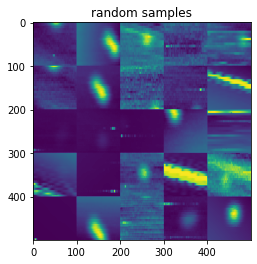

In [19]:
plot_sample_img(random.sample(fitting_rows, n_rows*n_cols), n_rows, n_cols, 'random samples')

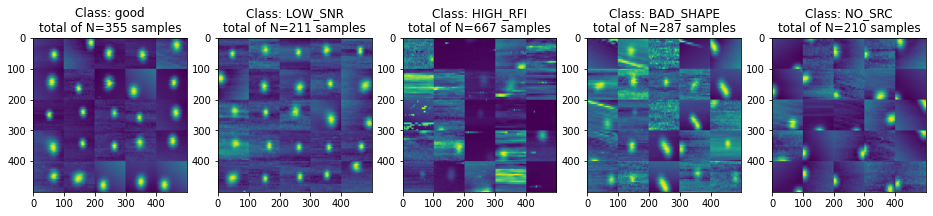

In [20]:
f, axs = plt.subplots(1, len(targets.unique()), figsize=(16,5))

for k, ax in zip(targets.unique(), axs):
    smpls = [r for r in fitting_rows if r['tags'] == k]
    plot_sample_img(random.sample(smpls, n_rows*n_cols), n_rows, n_cols, f'Class: {k}\ntotal of N={len(smpls)} samples', ax)

## Group some classes together to increase sample size (and performance?)

In [21]:
# groups = {
#    'good': ['good', 'LOW_SNR'],
#    'HIGH_RFI': ['HIGH_RFI'],
#    'BAD_SHAPE': ['BAD_SHAPE', 'NO_SRC']
# }

# for kg, vg in groups.items():
#     for i in range(len(fitting_rows)):
#         if fitting_rows[i]['tags'] in vg:
#             fitting_rows[i]['tags'] = kg

___
# Prepare the data used for fitting
___

In [22]:
targets = [r['tags'] for r in fitting_rows]
targets = pd.Series(targets)
counts = targets.value_counts()

n_good = counts['good']

display(counts)
display(counts / n_good)

HIGH_RFI     667
good         355
BAD_SHAPE    287
LOW_SNR      211
NO_SRC       210
dtype: int64

HIGH_RFI     1.878873
good         1.000000
BAD_SHAPE    0.808451
LOW_SNR      0.594366
NO_SRC       0.591549
dtype: float64

Get number of samples from class 'good' and round to nearest lower hundrets


In [23]:
n_per_class = counts['good'] #  // 100 * 100
n_per_class

355

In [24]:
# randomply select samples
input_data = []
for k in targets.unique():
    rows_i = [r for r in fitting_rows if r['tags'] == k]
    input_data += random.sample(rows_i, min(n_per_class, counts[k]))

# shuffle the selected samples
random.shuffle(input_data)


In [25]:
targets = [r['tags'] for r in input_data]
targets = pd.Series(targets)
counts = targets.value_counts()

n_good = counts['good']

display(counts)
display(counts / n_good)

good         355
HIGH_RFI     355
BAD_SHAPE    287
LOW_SNR      211
NO_SRC       210
dtype: int64

good         1.000000
HIGH_RFI     1.000000
BAD_SHAPE    0.808451
LOW_SNR      0.594366
NO_SRC       0.591549
dtype: float64

In [26]:
f, axs = plt.subplots(1, len(targets.unique()), figsize=(16,5))

for k, ax in zip(targets.unique(), axs):
    smpls = [r for r in input_data if r['tags'] == k]
    plot_sample_img(random.sample(smpls, n_rows*n_cols), n_rows, n_cols, f'Class: {k}\ntotal of N={len(smpls)} samples', ax)

In [27]:
df = pd.DataFrame(input_data)
df[[c for c in df.columns if c != 'image']]

obs_id                                           filename       tags  \
0      34621  /data/output/2023/10/02/EDD_2023-10-02T14:54:1...  BAD_SHAPE   
1      23247  /data/output/2023/03/21/EDD_2023-03-21T11:33:4...    LOW_SNR   
2      35196  /data/output/2023/10/09/EDD_2023-10-09T21:32:5...     NO_SRC   
3      23913  /data/output/2023/04/01/EDD_2023-04-01T16:26:1...       good   
4      34852  /data/output/2023/10/06/EDD_2023-10-06T14:53:3...    LOW_SNR   
...      ...                                                ...        ...   
1413   23750  /data/output/2023/03/30/EDD_2023-03-30T16:56:0...  BAD_SHAPE   
1414   23218  /data/output/2023/03/21/EDD_2023-03-21T04:05:1...  BAD_SHAPE   
1415   35134  /data/output/2023/10/09/EDD_2023-10-09T08:07:1...  BAD_SHAPE   
1416   35274  /data/output/2023/10/10/EDD_2023-10-10T13:54:0...  BAD_SHAPE   
1417   24060  /data/output/2023/04/03/EDD_2023-04-03T01:09:1...       good   

                  time_changed                classifier  \
0     2023-10-17 09:25:28.401Z                    manual   
1     2023-10-17 09:00:36.758Z                    manual   
2     2023-10-17 09:49:50.035Z                    manual   
3     2023-10-13 14:30:01.933Z  20231011_cnn_model.keras   
4     2023-10-17 09:32:20.731Z                    manual   
...                        ...                       ...   
1413  2023-10-17 09:08:49.444Z                    manual   
1414  2023-10-17 08:58:29.878Z                    manual   
1415  2023-10-17 09:48:05.730Z                    manual   
1416  2023-10-17 09:53:17.197Z                    manual   
1417  2023-10-13 14:22:06.138Z  20231011_cnn_model.keras   

                            clf_chksum                        sysinfo  
0                               manual  jovyan | Linux | 40217aae6c82  
1                               manual  jovyan | Linux | 40217aae6c82  
2                               manual  jovyan | Linux | 40217aae6c82  
3     2367e79ff710711caedd9f81fa75fddb  jovyan | Linux | 40217aae6c82  
4                               manual  jovyan | Linux | 40217aae6c82  
...                                ...                            ...  
1413                            manual  jovyan | Linux | 40217aae6c82  
1414                            manual  jovyan | Linux | 40217aae6c82  
1415                            manual  jovyan | Linux | 40217aae6c82  
1416                            manual  jovyan | Linux | 40217aae6c82  
1417  2367e79ff710711caedd9f81fa75fddb  jovyan | Linux | 40217aae6c82  

[1418 rows x 7 columns]

In [28]:
rows_backup = rows
rows = input_data

___
# TRAIN CLF
___

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [30]:
import keras
from keras import Sequential, Model, Input
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, LeakyReLU
# from keras.layers.advanced_activations import

from keras.utils import to_categorical



2023-10-19 19:21:58.919498: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-19 19:21:58.958145: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-19 19:21:58.958935: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-19 19:21:59.874802: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Make DataSet

In [31]:
# no resizing since it did not yield any accuracy improvement
resize = lambda img: img

# Make Model

In [36]:
targets = np.array([r['tags'] for r in rows])

classes = np.unique(targets).tolist()
classes

['BAD_SHAPE', 'HIGH_RFI', 'LOW_SNR', 'NO_SRC', 'good']

In [38]:
targets_int = np.array([classes.index(t) for t in targets])
targets_int

array([0, 2, 3, ..., 0, 0, 4])

In [45]:


X = np.array([resize(r['image']) for r in rows])

train_X, test_X, train_Y, test_Y = train_test_split(X, targets_int, test_size=0.25, stratify=targets_int)


_, n, m = train_X.shape
train_X = train_X.reshape(-1, n, m, 1)
test_X = test_X.reshape(-1, n, m, 1)

train_Y_by_class = []
test_Y_by_class = []

for i, c in enumerate(classes):
    train_Y_by_class.append((train_Y == i).astype(int).reshape(-1,1))
    test_Y_by_class.append((test_Y == i).astype(int).reshape(-1,1))

display(train_X.shape, test_X.shape, test_Y.shape, train_Y.shape)


print('training set shape:', train_X.shape)
print('validation set shape:', test_X.shape)

train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X / 255.
test_X = test_X / 255.

(1063, 100, 100, 1)

(355, 100, 100, 1)

(355,)

(1063,)

training set shape: (1063, 100, 100, 1)
validation set shape: (355, 100, 100, 1)


In [57]:
parts = pd.Series(targets).value_counts() / len(targets_int)
class_weights = parts.min() / parts
display(class_weights)
class_weights = [class_weights[c] for c in classes]
class_weights

good         0.591549
HIGH_RFI     0.591549
BAD_SHAPE    0.731707
LOW_SNR      0.995261
NO_SRC       1.000000
dtype: float64

[0.7317073170731707,
 0.5915492957746479,
 0.9952606635071091,
 1.0,
 0.5915492957746479]

In [ ]:
img_input = keras.Input(
    shape=(n,m,1), name="img_input"
)  # Variable-length sequence of ints


def get_graph(c):
    graph = []
    graph.append(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same'))
    graph.append(LeakyReLU(alpha=0.1))
    graph.append(MaxPooling2D((2, 2),padding='same'))
    graph.append(Conv2D(64, (3, 3), activation='linear',padding='same'))
    graph.append(LeakyReLU(alpha=0.1))
    graph.append(MaxPooling2D(pool_size=(2, 2),padding='same'))
    graph.append(Conv2D(128, (3, 3), activation='linear',padding='same'))
    graph.append(LeakyReLU(alpha=0.1))
    graph.append(MaxPooling2D(pool_size=(2, 2),padding='same'))
    graph.append(Flatten())
    graph.append(Dense(128, activation='linear'))
    graph.append(LeakyReLU(alpha=0.1))
    graph.append(Dense(1, activation='sigmoid', name=c))
    
    # stack the layers
    graph_model = img_input
    for g in graph:
        graph_model = g(graph_model)
    return graph_model

graphs = [get_graph(c) for c in classes]

# Instantiate an end-to-end model predicting both priority and department
model = keras.Model(
    inputs=[img_input],
    outputs=graphs,
)

model.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[c + 'accuracy' for c in classes],
    loss=[keras.losses.binary_crossentropy]*len(graphs),
    loss_weights=class_weights
)


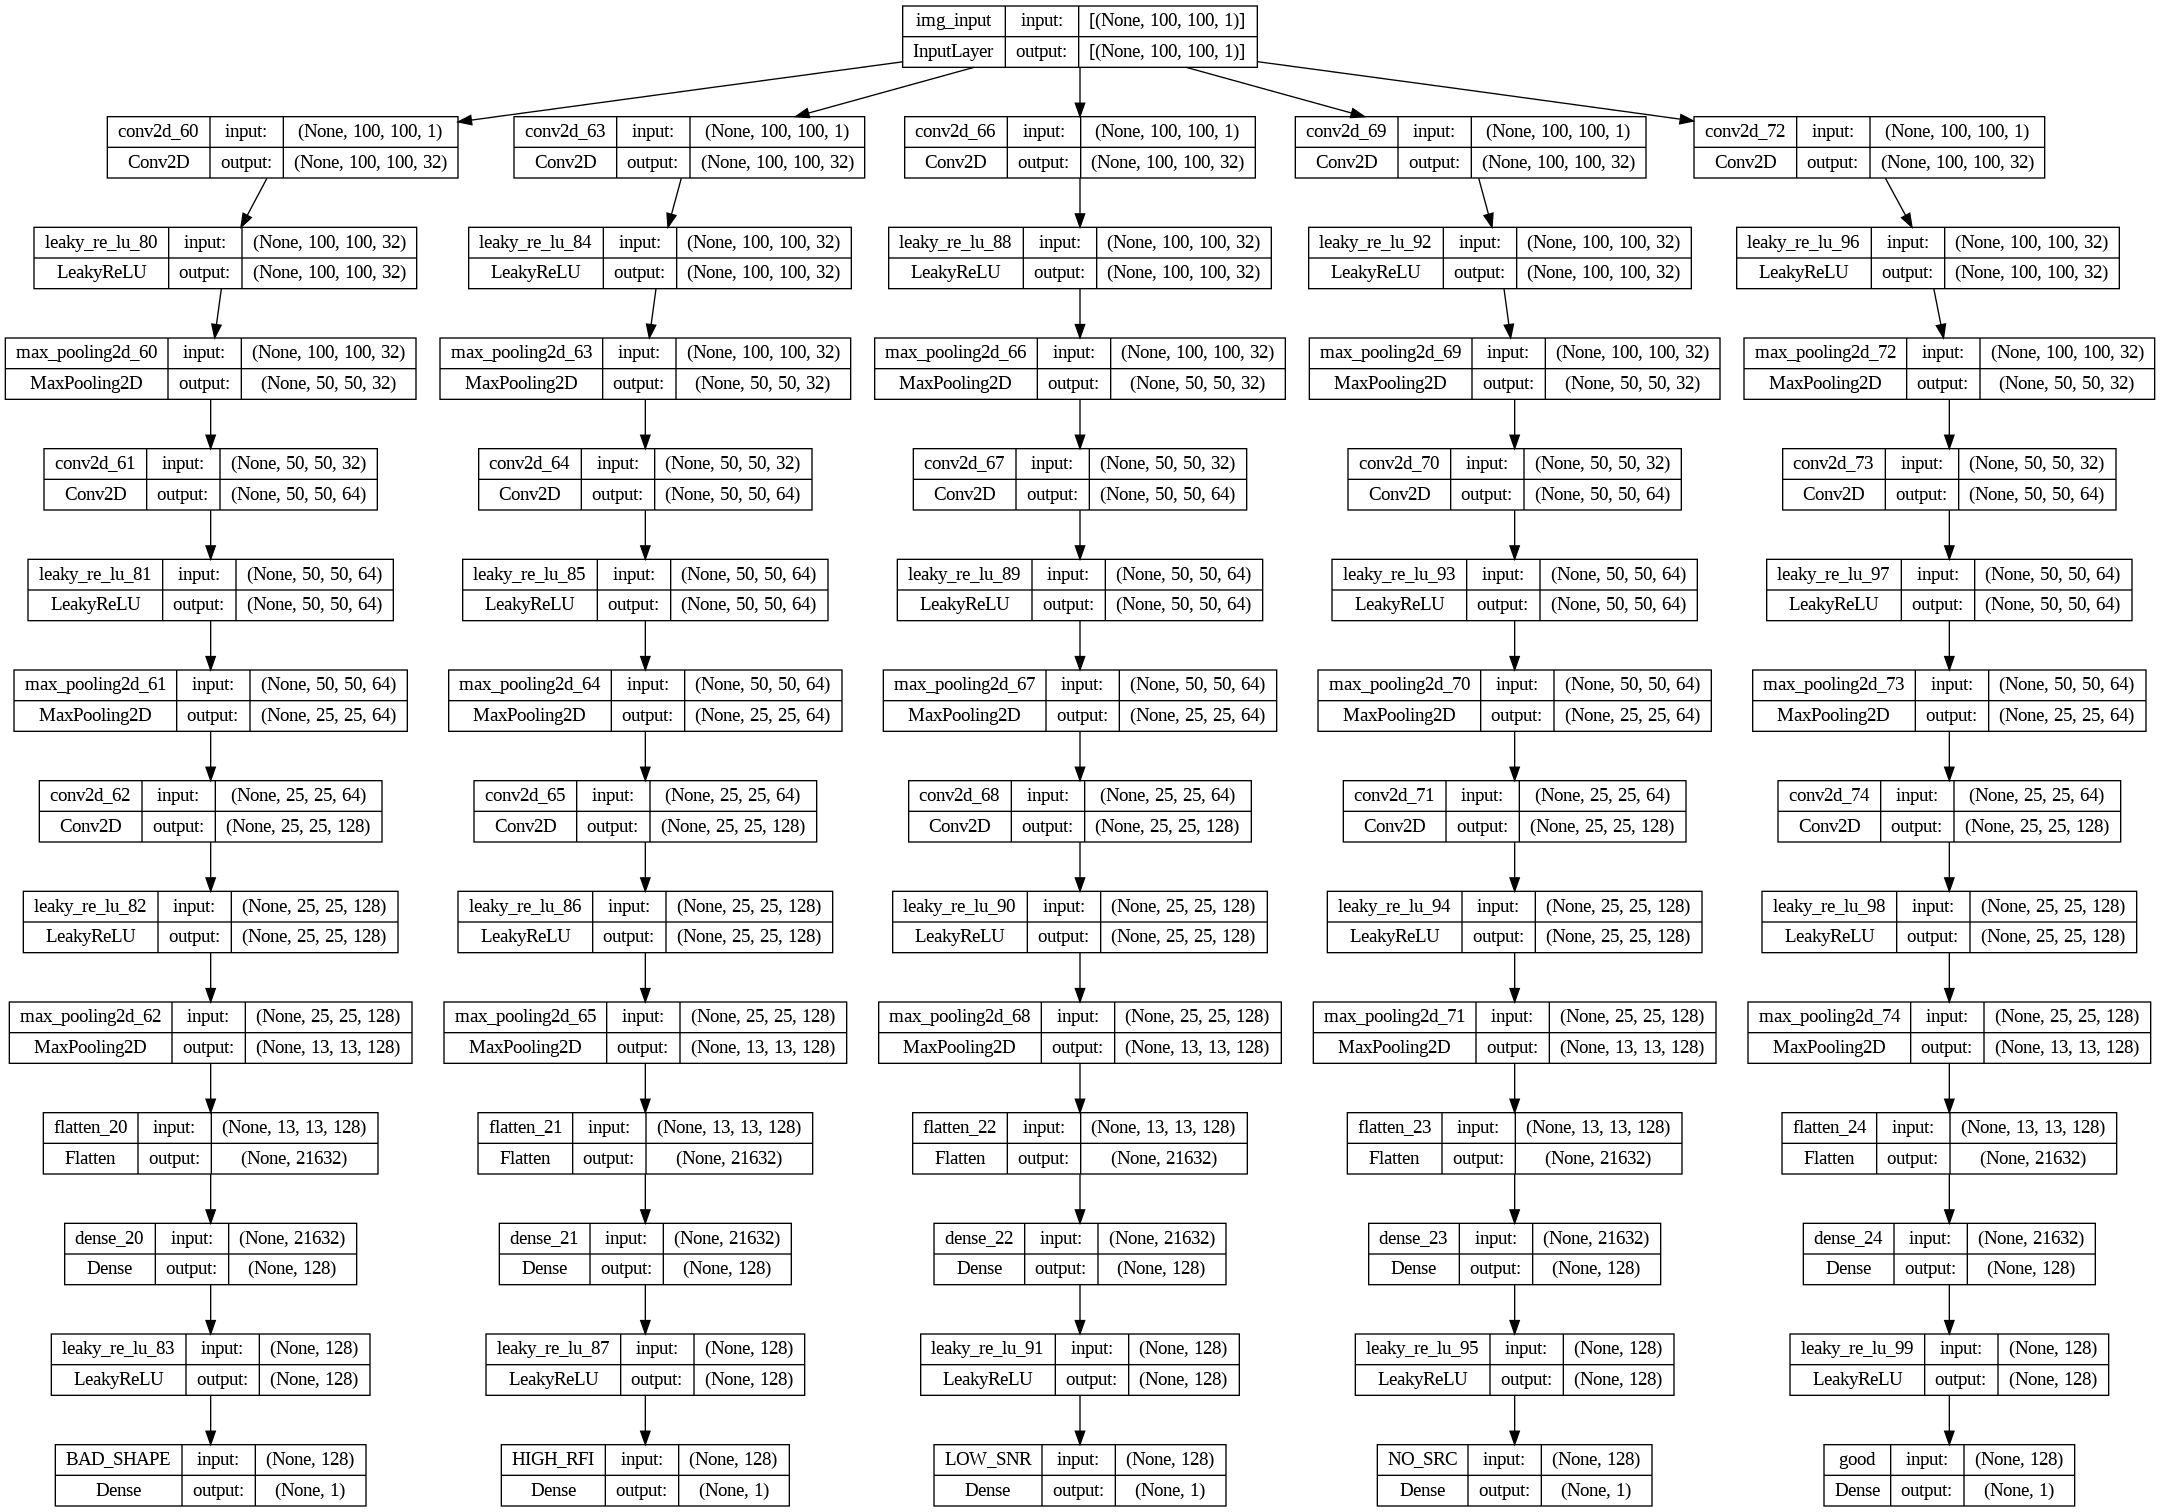

In [71]:
keras.utils.plot_model(model, "cnn_simo_model.png", show_shapes=True)

In [73]:
batch_size = 64
epochs = 20

model_train = model.fit(
    train_X,
    train_Y_by_class,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(test_X, test_Y_by_class)
)    

Epoch 1/20
17/17 [==============================] - 16s 933ms/step - loss: 0.7162 - BAD_SHAPE_loss: 0.2491 - HIGH_RFI_loss: 0.2180 - LOW_SNR_loss: 0.2241 - NO_SRC_loss: 0.0791 - good_loss: 0.1738 - val_loss: 1.3316 - val_BAD_SHAPE_loss: 0.4651 - val_HIGH_RFI_loss: 0.4625 - val_LOW_SNR_loss: 0.4342 - val_NO_SRC_loss: 0.1521 - val_good_loss: 0.2258
Epoch 2/20
17/17 [==============================] - 16s 932ms/step - loss: 0.6735 - BAD_SHAPE_loss: 0.2430 - HIGH_RFI_loss: 0.1886 - LOW_SNR_loss: 0.2161 - NO_SRC_loss: 0.0714 - good_loss: 0.1651 - val_loss: 1.4557 - val_BAD_SHAPE_loss: 0.4609 - val_HIGH_RFI_loss: 0.4976 - val_LOW_SNR_loss: 0.4871 - val_NO_SRC_loss: 0.1974 - val_good_loss: 0.2400
Epoch 3/20
17/17 [==============================] - 16s 935ms/step - loss: 0.6155 - BAD_SHAPE_loss: 0.2073 - HIGH_RFI_loss: 0.1768 - LOW_SNR_loss: 0.2051 - NO_SRC_loss: 0.0600 - good_loss: 0.1607 - val_loss: 1.4433 - val_BAD_SHAPE_loss: 0.4900 - val_HIGH_RFI_loss: 0.5325 - val_LOW_SNR_loss: 0.4574 - v

In [74]:
test_eval = model.evaluate(test_X, test_Y, verbose=0)

print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 127.79686737060547
Test accuracy: 28.486759185791016


In [87]:
test_eval

[127.79686737060547,
 28.486759185791016,
 25.26727294921875,
 39.19747543334961,
 40.908809661865234,
 20.43033790588379]

In [83]:
p = model.predict(test_X[0:,:,:,:])
p

12/12 [==============================] - 1s 82ms/step


[array([[1.87035810e-04],
        [3.45362489e-10],
        [2.08791595e-18],
        [9.97388244e-01],
        [1.21244568e-07],
        [3.04957268e-08],
        [7.09026179e-04],
        [3.66139119e-09],
        [4.84721661e-02],
        [1.13800681e-07],
        [2.53999926e-04],
        [4.31877152e-06],
        [5.63754838e-06],
        [7.93880284e-01],
        [5.68865624e-04],
        [2.52969767e-06],
        [5.19090430e-11],
        [9.74910498e-01],
        [2.60100327e-02],
        [2.97666986e-07],
        [9.51274706e-05],
        [4.50956140e-05],
        [2.33605579e-02],
        [8.38176202e-05],
        [9.00971543e-07],
        [2.29054921e-13],
        [5.63865967e-07],
        [5.56369650e-06],
        [2.84496394e-07],
        [9.22201480e-08],
        [1.29773639e-06],
        [1.21783125e-10],
        [2.17854563e-06],
        [1.42580956e-12],
        [1.16233487e-07],
        [1.50268408e-03],
        [8.25411260e-01],
        [1.35834896e-04],
        [4.6

In [86]:
p[0].shape

(355, 1)

In [80]:
12*

(355, 1)

In [ ]:

def train_tagging_model(c, batch_size = 64, epochs = 30):
    batch_size = 64
    epochs = 20
    train_X, test_X, test_Y, train_Y = make_fitting_data(c)

    num_classes = 2
    classes = ['', c]

    _, n, m, _ = train_X.shape
    model = make_tagging_model(n, m)
    display(model.summary())
    display(train_X.shape, train_Y.shape)

    model_train = model.fit(train_X, train_Y, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(test_X, test_Y))

    test_eval = model.evaluate(test_X, test_Y, verbose=0)

    print('Test loss:', test_eval[0])
    print('Test accuracy:', test_eval[1])

    accuracy = model_train.history['accuracy']
    val_accuracy = model_train.history['val_accuracy']
    loss = model_train.history['loss']
    val_loss = model_train.history['val_loss']
    epochs = range(len(accuracy))

    plt.figure()
    plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
    plt.title(c + ' | Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title(c + ' | Training and validation loss')
    plt.legend()



    predicted_classes = model.predict(test_X)
    # predicted_classes = np.round(predicted_classes).astype(int)

    map_fun = lambda x: (x >= 0.25).astype(int)
    predicted_classes = map_fun(predicted_classes.flatten())
    test_Y = map_fun(test_Y.flatten())

    display(predicted_classes[:1])

    f, axs = plt.subplots(3,3)
    axs = axs.flatten()
    correct = np.where(predicted_classes==test_Y)[0]
    print("Found {} correct labels".format(len(correct)))
    for i, correct in enumerate(correct[:9]):
        axs[i].imshow(test_X[correct].reshape(n,m), cmap='gray', interpolation='none')
        axs[i].set_title("Predicted {}, Class {}".format(predicted_classes[correct], test_Y[correct]), color='green')



    f, axs = plt.subplots(3,3)
    axs = axs.flatten()
    incorrect = np.where(predicted_classes!=test_Y)[0]
    print("Found {} incorrect labels".format(len(incorrect)))
    for i, incorrect in enumerate(incorrect[:9]):
        axs[i].imshow(test_X[incorrect].reshape(n,m), cmap='gray', interpolation='none')
        axs[i].set_title("Predicted {}, Class {}".format(predicted_classes[incorrect], test_Y[incorrect]), color='red')




    # target_names = ["Class {}".format(i) for i in range(n_classes)]
    print(classification_report(test_Y, predicted_classes, target_names=classes))

    test_Yc = [classes[i] for i in test_Y]
    predicted_classes_c = [classes[i] for i in predicted_classes]

    cm = confusion_matrix(test_Yc, predicted_classes_c, labels=classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    f, ax = plt.subplots(1,1)
    disp.plot(ax=ax)

    print('False Alarms:  {: 6.0f} ({:3.1f}% of all True alarms)'.format(cm[0,1], 100*cm[0,1]/np.sum(test_Y)))
    print('OK Alarms:     {: 6.0f} ({:3.1f}% of all True alarms)'.format(cm[1,1], 100*cm[1,1]/np.sum(test_Y)))
    print('Missed Alarms: {: 6.0f} ({:3.1f}% of all True alarms)'.format(cm[1,0], 100*cm[1,0]/np.sum(test_Y)))
    print('Passes:        {: 6.0f} ({:3.1f}% of all Passes)     '.format(cm[0,0], 100*cm[0,0]/(len(test_Y)-np.sum(test_Y))))
    plt.show()

    return model

# Train Model

####################################################################################################
####################################################################################################
    CLASS good
####################################################################################################
####################################################################################################
ALL     | Class ratio NO_TAG/good: 355/710 -> 0.5
TRAIN   | Class ratio NO_TAG/good: 266/532 -> 0.5
TEST    | Class ratio NO_TAG/good: 89/178 -> 0.5


(532, 100, 100, 1)

(178, 100, 100, 1)

(178, 1)

(532, 1)

training set shape: (532, 100, 100, 1)
validation set shape: (178, 100, 100, 1)
training label set shape: (178, 1)
validation label set shape: (178, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 100, 100, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 50, 50, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 50, 50, 64)        0         
                                    

None

(532, 100, 100, 1)

(532, 1)

Epoch 1/20
9/9 [==============================] - 3s 233ms/step - loss: 0.6320 - accuracy: 0.6880 - val_loss: 0.4639 - val_accuracy: 0.7584
Epoch 2/20
9/9 [==============================] - 2s 211ms/step - loss: 0.4356 - accuracy: 0.8064 - val_loss: 0.3792 - val_accuracy: 0.8315
Epoch 3/20
9/9 [==============================] - 2s 207ms/step - loss: 0.3499 - accuracy: 0.8327 - val_loss: 0.3008 - val_accuracy: 0.8483
Epoch 4/20
9/9 [==============================] - 2s 212ms/step - loss: 0.2882 - accuracy: 0.8609 - val_loss: 0.3151 - val_accuracy: 0.8371
Epoch 5/20
9/9 [==============================] - 2s 209ms/step - loss: 0.2865 - accuracy: 0.8665 - val_loss: 0.2440 - val_accuracy: 0.8764
Epoch 6/20
9/9 [==============================] - 2s 203ms/step - loss: 0.2484 - accuracy: 0.8703 - val_loss: 0.2265 - val_accuracy: 0.8876
Epoch 7/20
9/9 [==============================] - 2s 206ms/step - loss: 0.2145 - accuracy: 0.8929 - val_loss: 0.1957 - val_accuracy: 0.9101
Epoch 8/20
9/9 [====

array([1])

Found 164 correct labels
Found 14 incorrect labels
              precision    recall  f1-score   support

                   0.90      0.94      0.92        89
        good       0.94      0.90      0.92        89

    accuracy                           0.92       178
   macro avg       0.92      0.92      0.92       178
weighted avg       0.92      0.92      0.92       178

False Alarms:       5 (5.6% of all True alarms)
OK Alarms:         80 (89.9% of all True alarms)
Missed Alarms:      9 (10.1% of all True alarms)
Passes:            84 (94.4% of all Passes)     


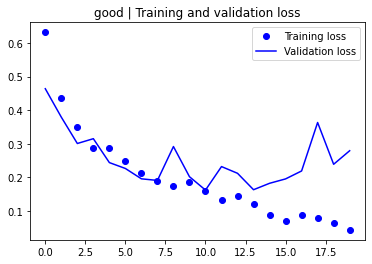

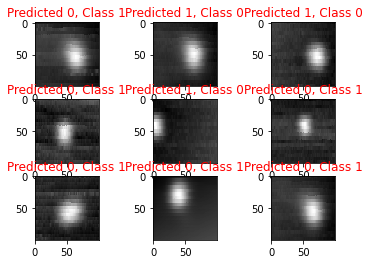

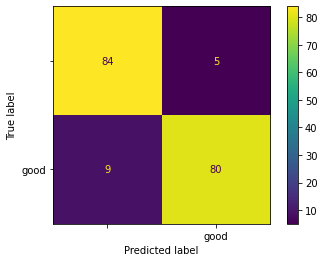

####################################################################################################
####################################################################################################
####################################################################################################
####################################################################################################
####################################################################################################
####################################################################################################
    CLASS LOW_SNR
####################################################################################################
####################################################################################################
ALL     | Class ratio NO_TAG/LOW_SNR: 211/422 -> 0.5
TRAIN   | Class ratio NO_TAG/LOW_SNR: 158/316 -> 0.5
TEST    | Class ratio NO_TAG/LOW_SNR: 53/106 -> 0.5


(316, 100, 100, 1)

(106, 100, 100, 1)

(106, 1)

(316, 1)

training set shape: (316, 100, 100, 1)
validation set shape: (106, 100, 100, 1)
training label set shape: (106, 1)
validation label set shape: (106, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 100, 100, 32)      320       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 100, 100, 32)      0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 50, 50, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 50, 50, 64)        0         
                                  

None

(316, 100, 100, 1)

(316, 1)

Epoch 1/20
5/5 [==============================] - 2s 256ms/step - loss: 0.6849 - accuracy: 0.5759 - val_loss: 0.6324 - val_accuracy: 0.7358
Epoch 2/20
5/5 [==============================] - 1s 223ms/step - loss: 0.5831 - accuracy: 0.7437 - val_loss: 0.4782 - val_accuracy: 0.7830
Epoch 3/20
5/5 [==============================] - 1s 222ms/step - loss: 0.5335 - accuracy: 0.7500 - val_loss: 0.5297 - val_accuracy: 0.6698
Epoch 4/20
5/5 [==============================] - 1s 224ms/step - loss: 0.4848 - accuracy: 0.7437 - val_loss: 0.4979 - val_accuracy: 0.6981
Epoch 5/20
5/5 [==============================] - 1s 223ms/step - loss: 0.4629 - accuracy: 0.7816 - val_loss: 0.4109 - val_accuracy: 0.8585
Epoch 6/20
5/5 [==============================] - 1s 223ms/step - loss: 0.4021 - accuracy: 0.8133 - val_loss: 0.3512 - val_accuracy: 0.8585
Epoch 7/20
5/5 [==============================] - 1s 229ms/step - loss: 0.3548 - accuracy: 0.8386 - val_loss: 0.3415 - val_accuracy: 0.8396
Epoch 8/20
5/5 [====

array([0])

Found 88 correct labels
Found 18 incorrect labels
              precision    recall  f1-score   support

                   0.93      0.72      0.81        53
     LOW_SNR       0.77      0.94      0.85        53

    accuracy                           0.83       106
   macro avg       0.85      0.83      0.83       106
weighted avg       0.85      0.83      0.83       106

False Alarms:      15 (28.3% of all True alarms)
OK Alarms:         50 (94.3% of all True alarms)
Missed Alarms:      3 (5.7% of all True alarms)
Passes:            38 (71.7% of all Passes)     


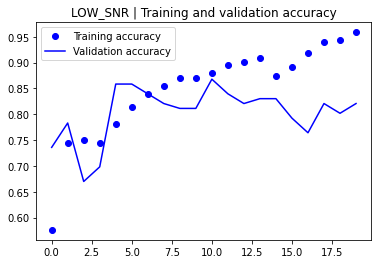

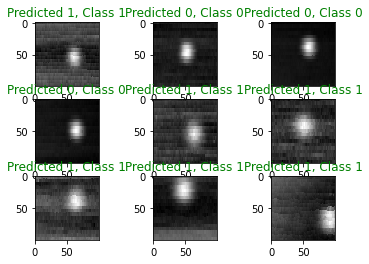

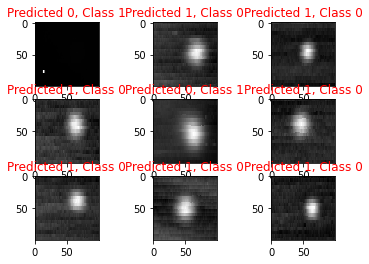

####################################################################################################
####################################################################################################
####################################################################################################
####################################################################################################
####################################################################################################
####################################################################################################
    CLASS HIGH_RFI
####################################################################################################
####################################################################################################
ALL     | Class ratio NO_TAG/HIGH_RFI: 355/710 -> 0.5
TRAIN   | Class ratio NO_TAG/HIGH_RFI: 266/532 -> 0.5
TEST    | Class ratio NO_TAG/HIGH_RFI: 89/178 -> 0.5


(532, 100, 100, 1)

(178, 100, 100, 1)

(178, 1)

(532, 1)

training set shape: (532, 100, 100, 1)
validation set shape: (178, 100, 100, 1)
training label set shape: (178, 1)
validation label set shape: (178, 1)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 100, 100, 32)      320       
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 100, 100, 32)      0         
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 50, 50, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 50, 50, 64)        0         
                                  

None

(532, 100, 100, 1)

(532, 1)

Epoch 1/20
9/9 [==============================] - 3s 222ms/step - loss: 0.5586 - accuracy: 0.7500 - val_loss: 0.3527 - val_accuracy: 0.8596
Epoch 2/20
9/9 [==============================] - 2s 210ms/step - loss: 0.2682 - accuracy: 0.8835 - val_loss: 0.2368 - val_accuracy: 0.8989
Epoch 3/20
9/9 [==============================] - 2s 206ms/step - loss: 0.1707 - accuracy: 0.9305 - val_loss: 0.2203 - val_accuracy: 0.8933
Epoch 4/20
9/9 [==============================] - 2s 203ms/step - loss: 0.1530 - accuracy: 0.9436 - val_loss: 0.1786 - val_accuracy: 0.9382
Epoch 5/20
9/9 [==============================] - 2s 207ms/step - loss: 0.1076 - accuracy: 0.9624 - val_loss: 0.1832 - val_accuracy: 0.9270
Epoch 6/20
9/9 [==============================] - 2s 208ms/step - loss: 0.0922 - accuracy: 0.9718 - val_loss: 0.1616 - val_accuracy: 0.9326
Epoch 7/20
9/9 [==============================] - 2s 206ms/step - loss: 0.0734 - accuracy: 0.9737 - val_loss: 0.1535 - val_accuracy: 0.9494
Epoch 8/20
9/9 [====

array([0])

Found 165 correct labels
Found 13 incorrect labels
              precision    recall  f1-score   support

                   0.90      0.96      0.93        89
    HIGH_RFI       0.95      0.90      0.92        89

    accuracy                           0.93       178
   macro avg       0.93      0.93      0.93       178
weighted avg       0.93      0.93      0.93       178

False Alarms:       4 (4.5% of all True alarms)
OK Alarms:         80 (89.9% of all True alarms)
Missed Alarms:      9 (10.1% of all True alarms)
Passes:            85 (95.5% of all Passes)     


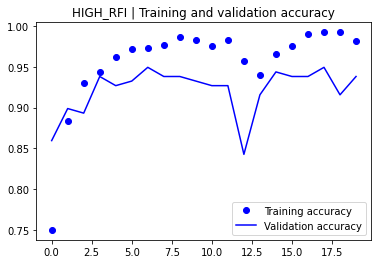

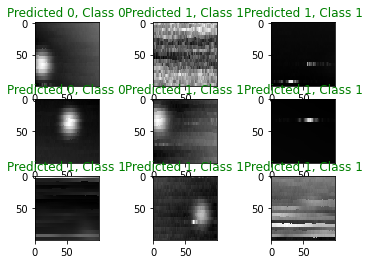

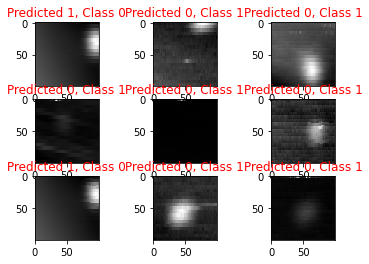

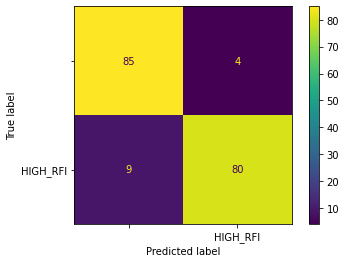

####################################################################################################
####################################################################################################
####################################################################################################
####################################################################################################
####################################################################################################
####################################################################################################
    CLASS NO_SRC
####################################################################################################
####################################################################################################
ALL     | Class ratio NO_TAG/NO_SRC: 210/420 -> 0.5
TRAIN   | Class ratio NO_TAG/NO_SRC: 158/315 -> 0.5015873015873016
TEST    | Class ratio NO_TAG/NO_SRC: 52/105 -> 0.4952380

(315, 100, 100, 1)

(105, 100, 100, 1)

(105, 1)

(315, 1)

training set shape: (315, 100, 100, 1)
validation set shape: (105, 100, 100, 1)
training label set shape: (105, 1)
validation label set shape: (105, 1)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 100, 100, 32)      320       
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 100, 100, 32)      0         
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 50, 50, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 50, 50, 64)        18496     
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 50, 50, 64)        0         
                                  

None

(315, 100, 100, 1)

(315, 1)

Epoch 1/20
5/5 [==============================] - 2s 258ms/step - loss: 0.4488 - accuracy: 0.8159 - val_loss: 0.2344 - val_accuracy: 0.9429
Epoch 2/20
5/5 [==============================] - 1s 219ms/step - loss: 0.2814 - accuracy: 0.9143 - val_loss: 0.2812 - val_accuracy: 0.9429
Epoch 3/20
5/5 [==============================] - 1s 219ms/step - loss: 0.2709 - accuracy: 0.9143 - val_loss: 0.1443 - val_accuracy: 0.9714
Epoch 4/20
5/5 [==============================] - 1s 220ms/step - loss: 0.1943 - accuracy: 0.9429 - val_loss: 0.1128 - val_accuracy: 0.9619
Epoch 5/20
5/5 [==============================] - 1s 226ms/step - loss: 0.1394 - accuracy: 0.9524 - val_loss: 0.0608 - val_accuracy: 0.9714
Epoch 6/20
5/5 [==============================] - 1s 220ms/step - loss: 0.1158 - accuracy: 0.9492 - val_loss: 0.0639 - val_accuracy: 0.9714
Epoch 7/20
5/5 [==============================] - 1s 219ms/step - loss: 0.1019 - accuracy: 0.9619 - val_loss: 0.0660 - val_accuracy: 0.9714
Epoch 8/20
5/5 [====

array([1])

Found 102 correct labels
Found 3 incorrect labels
              precision    recall  f1-score   support

                   1.00      0.94      0.97        53
      NO_SRC       0.95      1.00      0.97        52

    accuracy                           0.97       105
   macro avg       0.97      0.97      0.97       105
weighted avg       0.97      0.97      0.97       105

False Alarms:       3 (5.8% of all True alarms)
OK Alarms:         52 (100.0% of all True alarms)
Missed Alarms:      0 (0.0% of all True alarms)
Passes:            50 (94.3% of all Passes)     


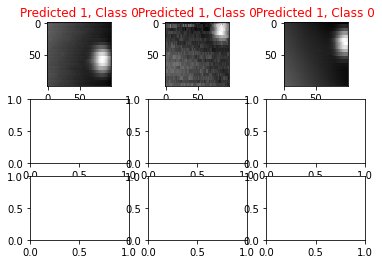

####################################################################################################
####################################################################################################
####################################################################################################
####################################################################################################
####################################################################################################
####################################################################################################
    CLASS BAD_SHAPE
####################################################################################################
####################################################################################################
ALL     | Class ratio NO_TAG/BAD_SHAPE: 287/574 -> 0.5
TRAIN   | Class ratio NO_TAG/BAD_SHAPE: 215/430 -> 0.5
TEST    | Class ratio NO_TAG/BAD_SHAPE: 72/144 -> 0.5


(430, 100, 100, 1)

(144, 100, 100, 1)

(144, 1)

(430, 1)

training set shape: (430, 100, 100, 1)
validation set shape: (144, 100, 100, 1)
training label set shape: (144, 1)
validation label set shape: (144, 1)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 100, 100, 32)      320       
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 100, 100, 32)      0         
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 50, 50, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 50, 50, 64)        18496     
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 50, 50, 64)        0         
                                  

None

(430, 100, 100, 1)

(430, 1)

Epoch 1/20
7/7 [==============================] - 2s 234ms/step - loss: 0.6107 - accuracy: 0.7186 - val_loss: 0.4436 - val_accuracy: 0.8056
Epoch 2/20
7/7 [==============================] - 1s 215ms/step - loss: 0.4417 - accuracy: 0.8000 - val_loss: 0.3676 - val_accuracy: 0.8403
Epoch 3/20
7/7 [==============================] - 1s 213ms/step - loss: 0.3780 - accuracy: 0.8419 - val_loss: 0.2902 - val_accuracy: 0.8681
Epoch 4/20
7/7 [==============================] - 1s 214ms/step - loss: 0.2897 - accuracy: 0.8512 - val_loss: 0.3018 - val_accuracy: 0.8681
Epoch 5/20
7/7 [==============================] - 2s 216ms/step - loss: 0.2408 - accuracy: 0.8930 - val_loss: 0.2712 - val_accuracy: 0.8819
Epoch 6/20
7/7 [==============================] - 1s 212ms/step - loss: 0.2291 - accuracy: 0.9140 - val_loss: 0.1926 - val_accuracy: 0.9236
Epoch 7/20
7/7 [==============================] - 2s 216ms/step - loss: 0.1610 - accuracy: 0.9465 - val_loss: 0.1707 - val_accuracy: 0.9306
Epoch 8/20
7/7 [====

array([0])

Found 134 correct labels
Found 10 incorrect labels
              precision    recall  f1-score   support

                   0.92      0.94      0.93        72
   BAD_SHAPE       0.94      0.92      0.93        72

    accuracy                           0.93       144
   macro avg       0.93      0.93      0.93       144
weighted avg       0.93      0.93      0.93       144

False Alarms:       4 (5.6% of all True alarms)
OK Alarms:         66 (91.7% of all True alarms)
Missed Alarms:      6 (8.3% of all True alarms)
Passes:            68 (94.4% of all Passes)     


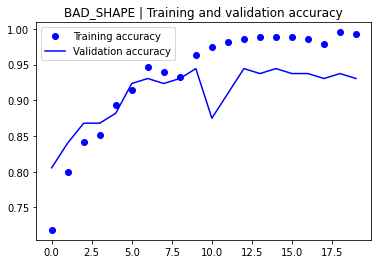

####################################################################################################
####################################################################################################
####################################################################################################
####################################################################################################


In [33]:

targets = pd.Series([r['tags'] for r in input_data])
classes = list(targets.unique())


classifs = {}
for c in classes:
    print('#'*100)
    print('#'*100)
    print('    CLASS ' + c)
    print('#'*100)
    print('#'*100)

    classifs[c] = train_tagging_model(c)

    print('#'*100)
    print('#'*100)
    print('#'*100)
    print('#'*100)


___
# Save the trained model
___

In [34]:
classifs.keys()

dict_keys(['good', 'LOW_SNR', 'HIGH_RFI', 'NO_SRC', 'BAD_SHAPE'])

In [35]:
pathes = {}
for c, model in classifs.items():
    
    out_mdl_name = datetime.datetime.now().strftime('%Y%m%d') + '_cnn_model_otf_ku_tag_{}.keras'.format(c)
    pathes[c] = out_mdl_name

    print(out_mdl_name)
    model.save("models/" + out_mdl_name)




20231019_cnn_model_otf_ku_tag_good.keras
20231019_cnn_model_otf_ku_tag_LOW_SNR.keras
20231019_cnn_model_otf_ku_tag_HIGH_RFI.keras
20231019_cnn_model_otf_ku_tag_NO_SRC.keras
20231019_cnn_model_otf_ku_tag_BAD_SHAPE.keras


In [36]:
# "/content/drive/MyDrive/data/" + out_mdl_name

In [37]:
    image = rows[0]['image']

    n, m = image.shape
    x = image.reshape(1, n, m, 1)

    x = x.astype(float)
    x -= np.min(x)
    x /= np.max(x)

    for tag, out_mdl_name in pathes.items():

        print(out_mdl_name)
        reconstructed_model = keras.models.load_model("models/" + out_mdl_name)
        model = classifs[tag]

        pc = model.predict(x, verbose = 0)
        prediction = tag if pc[0,0] > 0.25 else ''
        print('   model        --> classification: {} (scr: {:3.3f})'.format(prediction, pc[0,0]))

        pc = model.predict(x, verbose = 0)
        prediction = tag if pc[0,0] > 0.25 else ''
        print('   loaded model --> classification: {} (scr: {:3.3f})'.format(prediction, pc[0,0]))

20231019_cnn_model_otf_ku_tag_good.keras
   model        --> classification: good (scr: 0.997)
   loaded model --> classification: good (scr: 0.997)
20231019_cnn_model_otf_ku_tag_LOW_SNR.keras
   model        --> classification:  (scr: 0.004)
   loaded model --> classification:  (scr: 0.004)
20231019_cnn_model_otf_ku_tag_HIGH_RFI.keras
   model        --> classification:  (scr: 0.000)
   loaded model --> classification:  (scr: 0.000)
20231019_cnn_model_otf_ku_tag_NO_SRC.keras
   model        --> classification:  (scr: 0.000)
   loaded model --> classification:  (scr: 0.000)
20231019_cnn_model_otf_ku_tag_BAD_SHAPE.keras
   model        --> classification:  (scr: 0.000)
   loaded model --> classification:  (scr: 0.000)


In [38]:
os.getcwd()

'/home/jovyan/skampi-obs-flagging/src'